## Matheus Cerqueira e Pedro Hugo - ENGC67 - PROJETO 2

Expecificações de Projeto:

- Projetar, a partir de um filtro passa-baixas Butterworth de sexta ordem, um filtro discreto passa-baixas com frequência de corte (-3dB) ωc = 2π/3, usando o método de transformação bilinear. Fazer a implementação sob forma direta e sob forma em cascata;
- Representar os coeficientes em ponto flutuante (ex.: 0, 00423578 = 0, 423578 × 10⁻²) e diminuir progressivamente o número de casas decimais após a vírgula nas formas direta e em cascata para verificar a sensibilidade à quantização de parâmetros.
- Traçar a curva do módulo da resposta em frequência em dB para os casos de precisão infinita e precisão finita;
- Em seguida, para a representação em forma direta, refazer os filtros com as 3 transformações em frequência a seguir (Z⁻¹ = −z¹; Z⁻¹ = z⁻² e Z⁻¹ = −z⁻²) e traçar a curva do módulo em dB da resposta em frequência resultante;
- Usar os filtros para processar um sinal de áudio, ouvir os resultados e os avaliar perceptualmente.
- Avaliar, também, o espectro em função do tempo, do sinal de entrada e de saída utilizando um espectrograma.

# 1. Projetando o filtro passa-baixas via transformação bilinear

## 1.1. Definindo parâmetros do filtro *Butterworth* analógico

In [135]:
import numpy as np

ordem = 6  # Ordem do filtro
cutoff_freq = (2/3) * np.pi  # Frequência de corte em radianos / segundo

fs = 44100 # Frequência de amostragem para sinal de audio
wn = fs*cutoff_freq
fc = wn/(2*np.pi)


## 1.2. Criando o filtro analógico *Butterworth* na forma direta

In [136]:
from scipy.signal import butter, iirfilter

# Projeto do filtro Butterworth analógico
#butter_numerador, butter_denominador = butter(ordem, cutoff_freq, analog=True, output='ba')
butter_numerador, butter_denominador = iirfilter(ordem, wn,btype = 'lowpass',analog=True, ftype='butter')
print("Numerador:", butter_numerador)
print("Denominador:", butter_denominador)

Numerador: [6.20845044e+29]
Denominador: [1.00000000e+00 3.56862548e+05 6.36754392e+10 7.20302268e+15
 5.43208248e+20 2.59710665e+25 6.20845044e+29]


## 1.3. Criando o filtro passa-baixas discreto usando transformação bilinear (direta)

In [137]:
from scipy.signal import bilinear,dlti

# Frequência de amostragem
sampling_freq = 44100

# Transformação bilinear para filtro IIR na forma direta
#bilinear_numerador, bilinear_denominador = dlti(*bilinear(butter_numerador, butter_denominador, fs=sampling_freq))

filtz = dlti(*bilinear(butter_numerador, butter_denominador, fs=sampling_freq))

# Coeficientes do filtro em ponto flutuante
print("Forma direta (ponto flutuante):")
print("b:", filtz.num)
print("a:", filtz.den)

Forma direta (ponto flutuante):
b: [0.03391037 0.20346223 0.50865558 0.67820744 0.50865558 0.20346223
 0.03391037]
a: [1.         0.17415911 0.78901525 0.08259211 0.11713691 0.00554934
 0.0018111 ]


### 1.3.1. Gráfico do filtro passa-baixas discreto (direta)

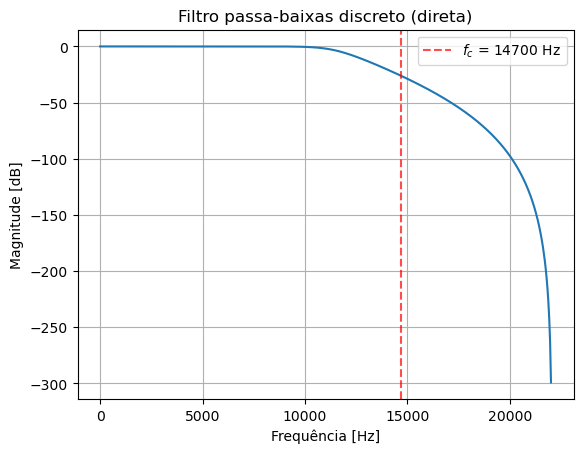

In [138]:
from scipy import signal
import matplotlib.pyplot as plt

bz,az = signal.freqz(filtz.num,filtz.den)

plt.plot(bz*fs/(2*np.pi), 20*np.log10(np.abs(az)))
plt.axvline(x=fc, color='red', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Filtro passa-baixas discreto (direta)')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## 1.4. Criando o filtro analógico *Butterworth* na forma cascata

In [139]:
# Projeto do filtro Butterworth analógico
butter_sos = butter(ordem, wn, analog=True, output='sos')
for sos in butter_sos:
  print("Bloco SOS: ", sos)

Bloco SOS:  [0.00000000e+00 0.00000000e+00 6.20845044e+29 1.00000000e+00
 1.78431274e+05 8.53089126e+09]
Bloco SOS:  [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 1.30620758e+05 8.53089126e+09]
Bloco SOS:  [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 4.78105158e+04 8.53089126e+09]


## 1.5. Criação do filtro passa-baixas discreto usando transformação bilinear (cascata)

In [140]:
from scipy.signal import butter, sosfilt, sos2tf, bilinear, zpk2tf
import numpy as np

# Frequência de amostragem normalizada
sampling_freq = 44100

z,p,k = butter(ordem, wn, analog=True, output='zpk')

b,a = zpk2tf(z,p,k)

b_bili,a_bili = bilinear(b,a,fs=sampling_freq)

print(b_bili)
print(a_bili)

# Transformação bilinear para cada seção do filtro em cascata
#for sos in butter_sos:
 # b, a = sos2tf(sos)

#print(b)
#print(a)

# Coeficientes do filtro em ponto flutuante
#print("Forma direta (ponto flutuante):")
#print("b:", bilinear_numerador)
#print("a:", bilinear_denominador)

[0.03391037 0.20346223 0.50865558 0.67820744 0.50865558 0.20346223
 0.03391037]
[1.         0.17415911 0.78901525 0.08259211 0.11713691 0.00554934
 0.0018111 ]


# 2. Mudança da precisão

## 2.1. Mudança de precisão da quantização da forma direta

In [141]:
import numpy as np

# Quantização dos coeficientes
decimal_points = [8, 6, 4, 2]  # Número de casas decimais após a vírgula para quantização
quantized_b_direto = []
quantized_a_direto = []

for dp in decimal_points:
  quantized_b_direto.append(np.round(filtz.num, dp))
  quantized_a_direto.append(np.round(filtz.den, dp))

for i in range(0, len(quantized_b_direto)):
  print("\nForma direta (", decimal_points[i], " casas decimais):")
  print("b:", quantized_b_direto[i])
  print("a:", quantized_a_direto[i])

#print(np.round())


Forma direta ( 8  casas decimais):
b: [0.03391037 0.20346223 0.50865558 0.67820744 0.50865558 0.20346223
 0.03391037]
a: [1.         0.17415911 0.78901525 0.08259211 0.11713691 0.00554934
 0.0018111 ]

Forma direta ( 6  casas decimais):
b: [0.03391  0.203462 0.508656 0.678207 0.508656 0.203462 0.03391 ]
a: [1.       0.174159 0.789015 0.082592 0.117137 0.005549 0.001811]

Forma direta ( 4  casas decimais):
b: [0.0339 0.2035 0.5087 0.6782 0.5087 0.2035 0.0339]
a: [1.     0.1742 0.789  0.0826 0.1171 0.0055 0.0018]

Forma direta ( 2  casas decimais):
b: [0.03 0.2  0.51 0.68 0.51 0.2  0.03]
a: [1.   0.17 0.79 0.08 0.12 0.01 0.  ]


### 2.1.1. Gráficos da mudança de precisão da quantização da forma direta

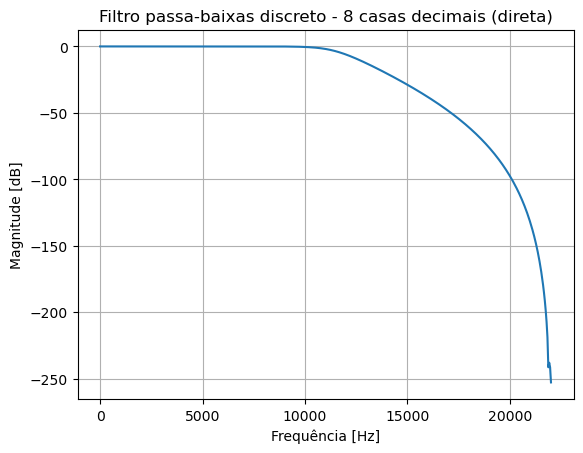

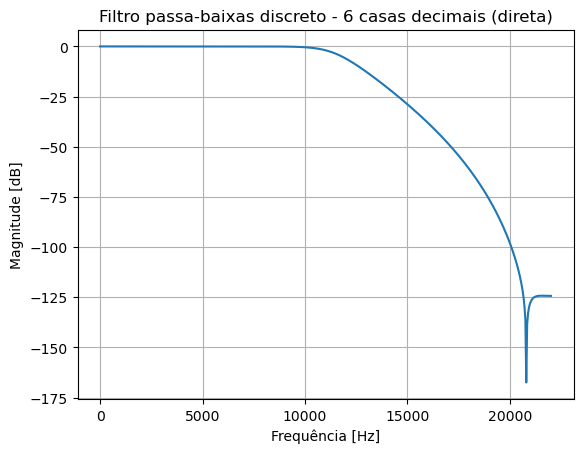

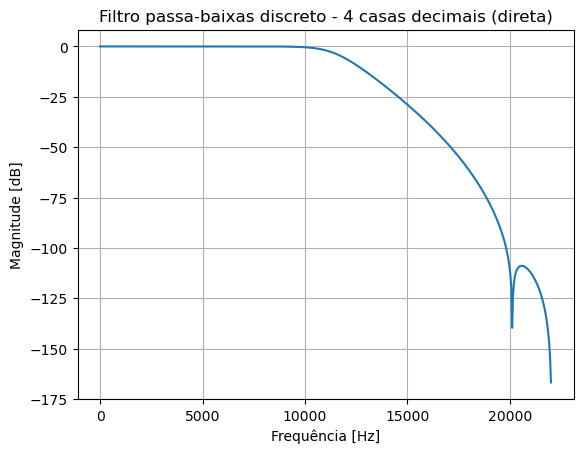

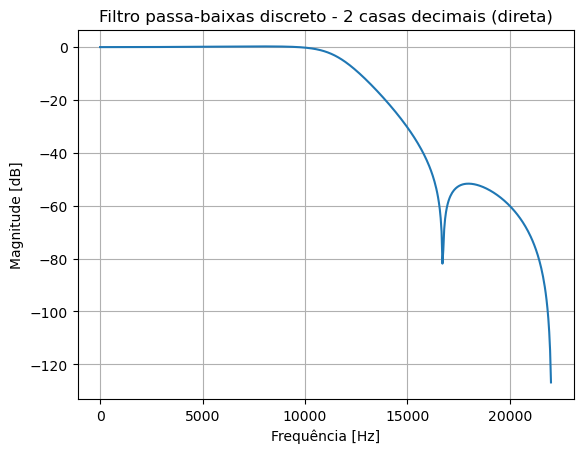

In [142]:
from scipy import signal
import matplotlib.pyplot as plt

for filtro in range(0,len(decimal_points)):
    bz,az = signal.freqz(quantized_b_direto[filtro],quantized_a_direto[filtro])
    plt.plot(bz*fs/(2*np.pi), 20*np.log10(np.abs(az)))
    # plt.axvline(x=fc, color='red', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
    # plt.legend()
    plt.title('Filtro passa-baixas discreto - '+str(decimal_points[filtro])+' casas decimais (direta)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid()
    plt.show()

## 2.2. Mudança na precisão da quantização da forma cascata

In [143]:
for dp in decimal_points:
  quantized_sos = np.round(sos, dp)
  print("\nForma cascata (", dp, " casas decimais):")
  print("a:", quantized_sos)


Forma cascata ( 8  casas decimais):
a: [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 4.78105158e+04 8.53089126e+09]

Forma cascata ( 6  casas decimais):
a: [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 4.78105158e+04 8.53089126e+09]

Forma cascata ( 4  casas decimais):
a: [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 4.78105158e+04 8.53089126e+09]

Forma cascata ( 2  casas decimais):
a: [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 4.78105200e+04 8.53089126e+09]


# Gráficos

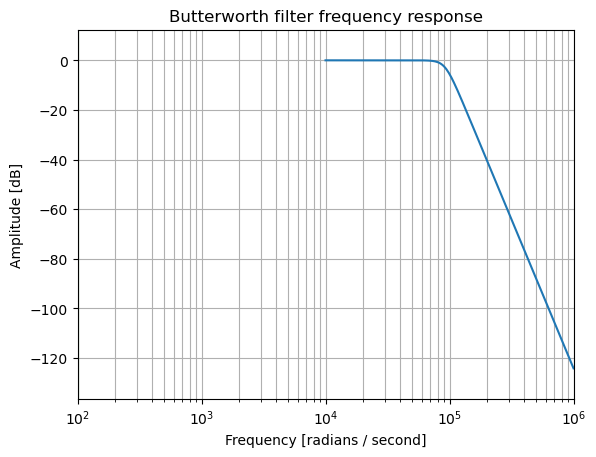

In [144]:
import matplotlib.pyplot as plt
from scipy.signal import freqs

w, h = freqs(butter_numerador, butter_denominador)

plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Butterworth filter frequency response')

plt.xlabel('Frequency [radians / second]')

plt.ylabel('Amplitude [dB]')

plt.margins(0, 0.1)

plt.grid(which='both', axis='both')

plt.axvline(100, color='green') # cutoff frequency

plt.show()

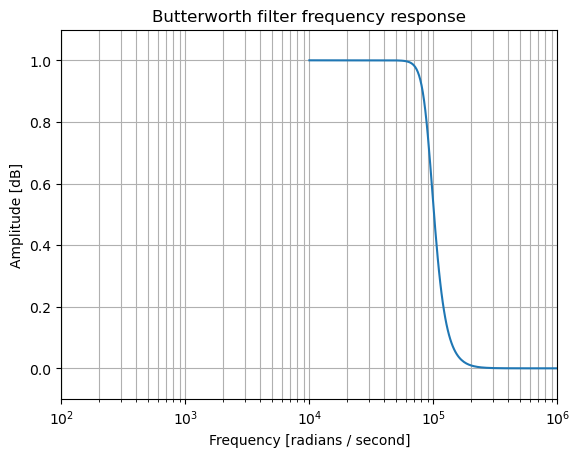

In [145]:
import matplotlib.pyplot as plt
from scipy.signal import freqs

w, h = freqs(butter_numerador, butter_denominador)

plt.semilogx(w, (abs(h)))

plt.title('Butterworth filter frequency response')

plt.xlabel('Frequency [radians / second]')

plt.ylabel('Amplitude [dB]')

plt.margins(0, 0.1)

plt.grid(which='both', axis='both')

plt.axvline(100, color='green') # cutoff frequency

plt.show()


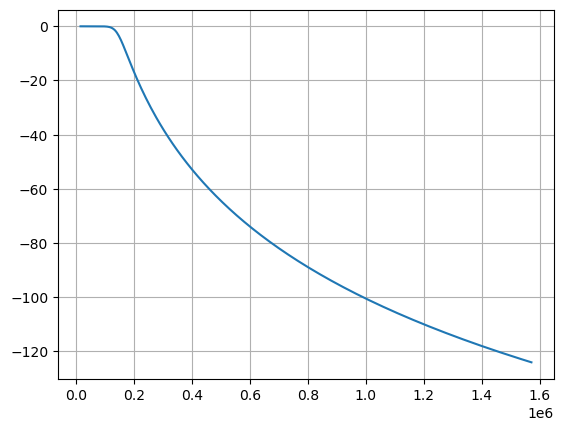

In [146]:
import matplotlib.pyplot as plt
from scipy.signal import freqs

ws2,hs2 = freqs(butter_numerador, butter_denominador)

wsHz2 = ws2/2*np.pi

plt.plot(wsHz2,20 * np.log10(np.abs(hs2)))
plt.grid()
plt.show()

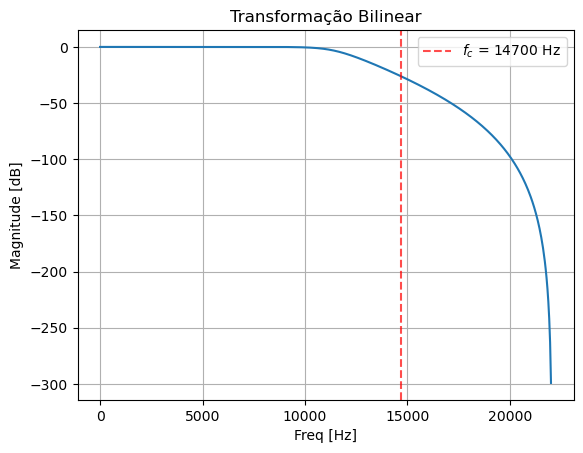

In [147]:
from scipy import signal
import matplotlib.pyplot as plt

bz,az = signal.freqz(filtz.num,filtz.den)

plt.plot(bz*fs/(2*np.pi), 20*np.log10(np.abs(az)))
plt.axvline(x=fc, color='red', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# Tentativa da transformação de lp para hp

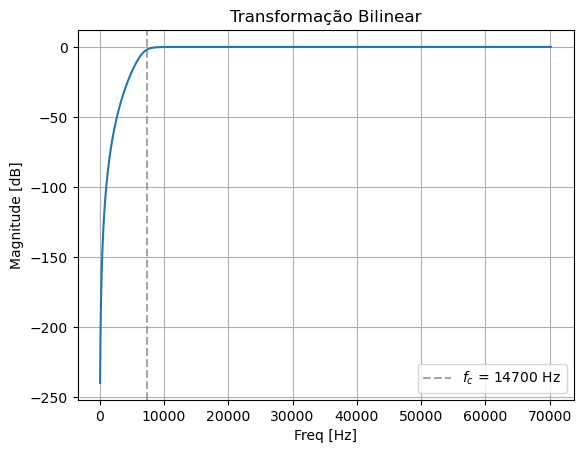

In [148]:
from scipy import signal

hp_num,hp_den = signal.lp2hp(butter_numerador, butter_denominador,wn)
bsh,ash = signal.freqs(hp_num,hp_den)

plt.plot(bsh*fs/(2*np.pi), 20*np.log10(np.abs(ash)))
plt.axvline(x=fc/2, color='gray', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# Tentativa da transformação de lp para lp

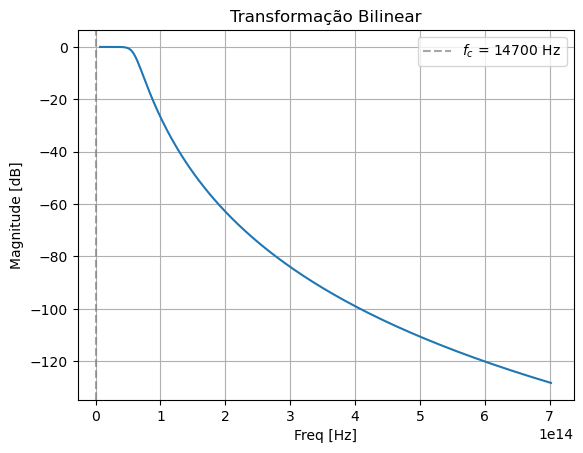

In [149]:
from scipy import signal

hp_num,hp_den = signal.lp2lp(butter_numerador, butter_denominador,wn)
filtz = dlti(*bilinear(hp_num, hp_den, fs=sampling_freq))

bsh,ash = signal.freqs(hp_num,hp_den)
bzh,azh = signal.freqz(filtz.num,filtz.den)

plt.plot(bsh*fs/(2*np.pi), 20*np.log10(np.abs(ash)))
plt.axvline(x=fc, color='gray', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# Tentativa da transformação de lp para bp

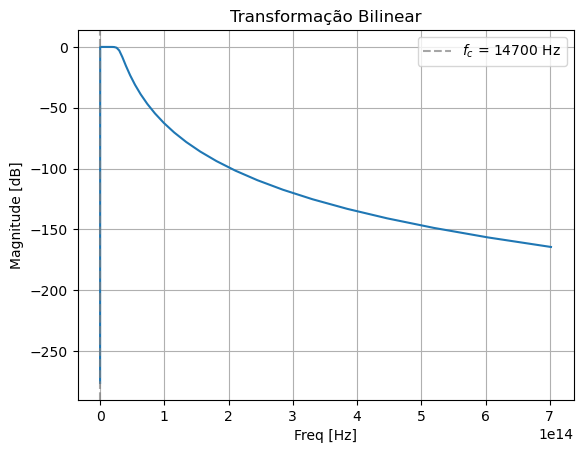

In [150]:
from scipy import signal

hp_num,hp_den = signal.lp2bp(butter_numerador, butter_denominador,wn, wn/2)
filtz = dlti(*bilinear(hp_num, hp_den, fs=sampling_freq))

bsh,ash = signal.freqs(hp_num,hp_den)
bzh,azh = signal.freqz(filtz.num,filtz.den)

plt.plot(bsh*fs/(2*np.pi), 20*np.log10(np.abs(ash)))
plt.axvline(x=fc, color='gray', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

# Tentativa da transformação de lp para hp discreto

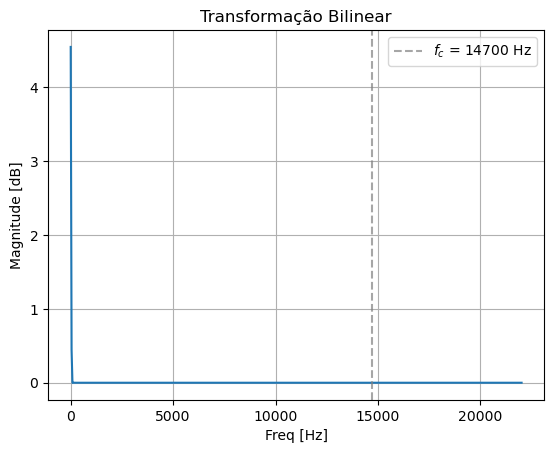

In [151]:
from scipy import signal

hp_num,hp_den = signal.lp2hp(butter_numerador, butter_denominador,wn)
filtz = dlti(*bilinear(hp_num, hp_den, fs=sampling_freq))
bzh,azh = signal.freqz(filtz.num,filtz.den)

plt.plot(bzh*fs/(2*np.pi), 20*np.log10(np.abs(azh)))
plt.axvline(x=fc, color='gray', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()